In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df_all = pd.read_csv('../Output/Submission/features/features_all.csv')
df_all = df_all[df_all['ContourType'] == 'Manual']
# drop min and max
df_all = df_all[~df_all['Feature'].isin(['firstorder_Minimum', 'firstorder_Maximum'])]
df_result = pd.DataFrame()

patIDs = df_all['PatID'].unique()
fts = df_all['Feature'].unique()

df_all = df_all[['PatID', 'Feature', 'Fraction', 'FeatureValue']]
df_all.drop_duplicates(subset=['PatID', 'Feature', 'Fraction'], keep='first', inplace=True)




In [79]:
# loop through all patients and trajectories
# calculate the abs change in feature value from the first fraction to all others

df_frac1_comp = pd.DataFrame()


for patID in patIDs:
    df_pat = df_all[df_all['PatID'] == patID]
    for ft in fts:
        df_ft = df_pat[df_pat['Feature'] == ft]
        df_ft = df_ft.sort_values('Fraction')
        df_ft['AbsChange'] = abs(df_ft['FeatureValue'] - df_ft['FeatureValue'].iloc[0])
        df_frac1_comp = pd.concat([df_frac1_comp, df_ft])

df_frac1_comp = df_frac1_comp[df_frac1_comp['Fraction'] != 1]




In [80]:
df_frac1_comp

,PatID,Feature,Fraction,FeatureValue,AbsChange
107,1642,shape_Elongation,2,0.884917,0.045160
214,1642,shape_Elongation,3,0.904351,0.064594
321,1642,shape_Elongation,4,0.972982,0.133224
428,1642,shape_Elongation,5,0.966507,0.126749
108,1642,shape_Flatness,2,0.773762,0.094457
...,...,...,...,...,...
21398,1303,ngtdm_Contrast,5,0.009259,0.002240
21078,1303,ngtdm_Strength,2,0.334714,0.010887
21185,1303,ngtdm_Strength,3,0.480682,0.135081
21292,1303,ngtdm_Strength,4,0.641976,0.296375


In [81]:
# loop over all features and pats and get the timepoint with the highest abs change
df_max_abs_change = pd.DataFrame()

for patID in patIDs:
    df_pat = df_frac1_comp[df_frac1_comp['PatID'] == patID]
    for ft in fts:
        df_ft = df_pat[df_pat['Feature'] == ft]
        df_ft = df_ft.sort_values('AbsChange', ascending=False)
        # get the row with the highest abs change
        max_change = df_ft.iloc[0]['AbsChange']
        df_max_row = df_ft[df_ft['AbsChange'] == max_change]
        df_max_row.drop_duplicates(subset=['PatID', 'Feature'], keep='first', inplace=True)
        df_max_abs_change = pd.concat([df_max_abs_change, df_max_row])
        

c:\Users\b01297ar\Documents\ProstateMRL-local\ProstateMRL-Radiomics\envPR\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == "":
c:\Users\b01297ar\Documents\ProstateMRL-local\ProstateMRL-Radiomics\envPR\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == "":
c:\Users\b01297ar\Documents\ProstateMRL-local\ProstateMRL-Radiomics\envPR\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https:

In [82]:
df_max_abs_change

,PatID,Feature,Fraction,FeatureValue,AbsChange
321,1642,shape_Elongation,4,0.972982,0.133224
429,1642,shape_Flatness,5,0.816565,0.137260
109,1642,shape_LeastAxisLength,2,28.050987,4.562428
110,1642,shape_MajorAxisLength,2,36.252723,1.675383
111,1642,shape_Maximum2DDiameterColumn,2,42.688141,2.637868
...,...,...,...,...,...
21395,1303,ngtdm_Busyness,5,22.938572,6.235279
21396,1303,ngtdm_Coarseness,5,0.000624,0.000337
21290,1303,ngtdm_Complexity,4,149.855911,64.436429
21291,1303,ngtdm_Contrast,4,0.006579,0.004919


In [83]:
print(df_max_abs_change.PatID.nunique())
print(df_max_abs_change.Feature.nunique())
print(df_max_abs_change.Fraction.nunique())
print(df_max_abs_change.shape)

20
105
4
(2100, 5)


In [84]:
# find the fraction that appears most often
df_max_abs_change['Fraction'].value_counts()

5    644
4    565
2    453
3    438
Name: Fraction, dtype: int64

In [85]:
# loop over all features and pats
# loop over all fractions and get the two fractions with the highest abs change
df_fracAB_comp = pd.DataFrame()
fractions = df_all['Fraction'].unique()

for patID in patIDs:
    df_pat = df_all[df_all['PatID'] == patID]
    for ft in fts:
        df_ft = df_pat[df_pat['Feature'] == ft]
        
        for fracA in fractions:
            fracA_val = df_ft[df_ft['Fraction'] == fracA]['FeatureValue'].values[0]
            
            for fracB in fractions:
                if fracB > fracA:
            
                    fracB_val = df_ft[df_ft['Fraction'] == fracB]['FeatureValue'].values[0]

                    abs_change = abs(fracA_val - fracB_val)

                    df_row = pd.DataFrame({'PatID': patID, 'Feature': ft, 'Fractions': f'{fracA}-{fracB}', 'AbsChange': abs_change}, index=[0])
                    df_fracAB_comp = pd.concat([df_fracAB_comp, df_row])

df_fracAB_comp

,PatID,Feature,Fractions,AbsChange
0,1642,shape_Elongation,1-2,0.045160
0,1642,shape_Elongation,1-3,0.064594
0,1642,shape_Elongation,1-4,0.133224
0,1642,shape_Elongation,1-5,0.126749
0,1642,shape_Elongation,2-3,0.019434
...,...,...,...,...
0,1303,ngtdm_Strength,2-4,0.307262
0,1303,ngtdm_Strength,2-5,0.101622
0,1303,ngtdm_Strength,3-4,0.161294
0,1303,ngtdm_Strength,3-5,0.247590


In [86]:
# for each patid and feature, get the fraction pair with the highest abs change
df_max_changeAB = df_fracAB_comp.groupby(['PatID', 'Feature']).apply(lambda x: x[x['AbsChange'] == x['AbsChange'].max()]).reset_index(drop=True)
df_max_changeAB.drop_duplicates(subset=['PatID', 'Feature'], keep='first', inplace=True)
df_max_changeAB



,PatID,Feature,Fractions,AbsChange
0,653,firstorder_10Percentile,1-4,1.900000e+01
1,653,firstorder_90Percentile,2-5,3.800000e+01
2,653,firstorder_Energy,2-5,9.694425e+07
3,653,firstorder_Entropy,2-5,5.456507e-01
4,653,firstorder_InterquartileRange,2-4,1.400000e+01
...,...,...,...,...
2111,1642,shape_MinorAxisLength,1-4,4.362088e+00
2112,1642,shape_Sphericity,3-5,1.831857e-02
2113,1642,shape_SurfaceArea,1-2,9.154177e+02
2114,1642,shape_SurfaceVolumeRatio,1-2,1.952753e-02


In [87]:
df_max_changeAB['Fractions'].value_counts()

1-5    365
1-4    346
2-5    338
1-3    244
1-2    182
3-5    163
3-4    134
4-5    133
2-4    118
2-3     77
Name: Fractions, dtype: int64

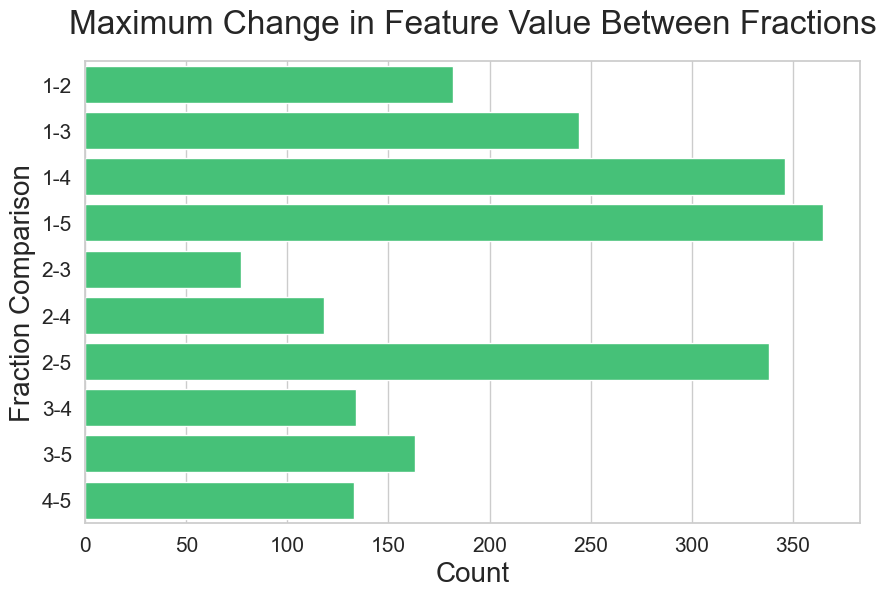

In [98]:
# bar plot of the fraction pairs with the highest abs change
df_bar = df_max_changeAB['Fractions'].value_counts().reset_index()
df_bar.columns = ['Fractions', 'Count']
df_bar['fracA'] = df_bar['Fractions'].apply(lambda x: x.split('-')[0])
df_bar['fracB'] = df_bar['Fractions'].apply(lambda x: x.split('-')[1])

df_bar = df_bar.sort_values(['fracA', 'fracB'], ascending=[True, True])
sns.set(style='whitegrid')
plt.figure(figsize=(10, 6))
# barplot horizontal
sns.barplot(x='Count', y='Fractions', data=df_bar, color='#31D574')

plt.xlabel('Count', fontsize=20)
plt.ylabel('Fraction Comparison', fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.title('Maximum Change in Feature Value Between Fractions', fontsize=24, pad=20)
plt.savefig('./MaxChangeBar.png', dpi=300)


